In [26]:
from pathlib import Path

if Path.cwd().stem == "features":
    %cd ../..
    %load_ext autoreload
    %autoreload 2

In [27]:
import logging
import os
from dataclasses import dataclass
from functools import reduce, wraps
from pathlib import Path
from typing import Dict, List

import holoviews as hv
import hvplot.polars
import matplotlib.pyplot as plt
import neurokit2 as nk
import numpy as np
import pandas as pd
import panel as pn
import plotly.express as px
import plotly.io as pio
import polars as pl

from src.data.config_data import DataConfigBase
from src.data.config_data_imotions import IMOTIONS_DICT, IMOTIONS_LIST, iMotionsConfig
from src.data.config_data_interim import INTERIM_DICT, INTERIM_LIST, InterimConfig
from src.data.config_data_raw import RAW_DICT, RAW_LIST, RawConfig
from src.data.config_participant import PARTICIPANT_LIST, ParticipantConfig
from src.data.make_dataset import load_dataset, load_participant_datasets
from src.data.utils import merge_datasets
from src.features.quality_checks import check_sample_rate
from src.features.scaling import scale_min_max, scale_standard
from src.features.stimulus import corr_temperature_rating
from src.features.transformations import (
    add_timedelta_column,
    interpolate,
    map_participant_datasets,
    map_trials,
)
from src.log_config import configure_logging
from src.visualization.plot_data import (
    plot_data_panel,
    plot_trial_matplotlib,
    plot_trial_plotly,
)

configure_logging(
    stream_level=logging.DEBUG,
    ignore_libs=["matplotlib", "Comm", "bokeh", "tornado"],
)

hv.extension("plotly")
pio.templates.default = "plotly_white"  # set plotly theme
pl.Config.set_tbl_rows(12)
plt.rcParams["figure.figsize"] = [15, 5]  # default is [6, 4]

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

In [28]:
dfs = load_participant_datasets(PARTICIPANT_LIST[4], INTERIM_LIST)

16:02:33 | DEBUG   | make_dataset | Dataset 'stimulus' for participant 4000 loaded from data/interim/4000/4000_stimulus.csv
16:02:33 | DEBUG   | make_dataset | Dataset 'eeg' for participant 4000 loaded from data/interim/4000/4000_eeg.csv
16:02:33 | DEBUG   | make_dataset | Dataset 'eda' for participant 4000 loaded from data/interim/4000/4000_eda.csv
16:02:33 | DEBUG   | make_dataset | Dataset 'ppg' for participant 4000 loaded from data/interim/4000/4000_ppg.csv
16:02:33 | DEBUG   | make_dataset | Dataset 'pupillometry' for participant 4000 loaded from data/interim/4000/4000_pupillometry.csv
16:02:33 | DEBUG   | make_dataset | Dataset 'affectiva' for participant 4000 loaded from data/interim/4000/4000_affectiva.csv
16:02:33 | INFO    | make_dataset | Participant 4000 loaded with datasets: dict_keys(['stimulus', 'eeg', 'eda', 'ppg', 'pupillometry', 'affectiva'])


In [29]:
merge_on = ["Timestamp", "Participant", "Trial"]
stimuli = dfs.stimulus.join(
    dfs.affectiva,
    on=merge_on,
    how="full",
    coalesce=True,
).sort(["Participant", "Trial", "Timestamp"])

In [30]:
stimuli

Timestamp,Temperature,Rating,Stimulus_Seed,Participant,Trial,Skin_Area,Anger,Contempt,Disgust,Fear,Joy,Sadness,Surprise,Engagement,Valence,Sentimentality,Confusion,Neutral,Attention,Brow Furrow,Brow Raise,Cheek Raise,Chin Raise,Dimpler,Eye Closure,Eye Widen,Inner Brow Raise,Jaw Drop,Lip Corner Depressor,Lip Press,Lip Pucker,Lip Stretch,Lip Suck,Lid Tighten,Mouth Open,Nose Wrinkle,Smile,Smirk,Upper Lip Raise,Blink,BlinkRate,Pitch,Yaw,Roll,Interocular Distance
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
232094.6628,0.0,1.0,243.0,4000.0,0.0,6.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
232153.5045,null,null,null,4000.0,0.0,null,0.00044,0.00049,0.0002,0.00221,0.00024,0.00084,0.00865,0.04606,0.0,0.00004,0.00004,0.98269,0.96313,0.00004,0.54803,0.0001,0.0,0.0,0.0,0.00242,0.11082,0.00084,0.0,0.0,0.0,0.0,0.0,0.0,0.00814,0.0,0.00073,0.00013,0.0,0.0,0.18,-0.11331,-0.05685,0.00608,0.87872
232236.2837,0.000204,1.0,243.0,4000.0,0.0,6.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
232245.2596,null,null,null,4000.0,0.0,null,0.0005,0.0005,0.00023,0.00188,0.00024,0.00068,0.00702,0.04866,0.0,0.00001,0.00001,0.98596,0.95641,0.00001,0.53881,0.00013,0.0,0.0,0.0,0.00252,0.06203,0.0082,0.0,0.00001,0.0,0.0,0.0,0.0,0.02454,0.0,0.00084,0.00036,0.0,0.0,0.18,-0.10684,-0.06558,0.0085,0.87017
232336.518,0.000817,1.0,243.0,4000.0,0.0,6.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
232341.5042,null,null,null,4000.0,0.0,null,0.00073,0.00092,0.00023,0.00073,0.00024,0.00084,0.00222,0.00731,0.0,0.00007,0.00003,0.99555,0.96249,0.00003,0.30988,0.00012,0.0,0.00184,0.0,0.001,0.02295,0.00059,0.0,0.00007,0.0,0.00001,0.0,0.0,0.00254,0.0,0.00108,0.00371,0.0,0.0,0.18,-0.09062,-0.05775,0.01881,0.88479
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2.9197e6,null,null,null,4000.0,11.0,null,0.00059,0.00077,0.00021,0.00111,0.00024,0.00104,0.00376,0.01091,0.0,0.0,0.00003,0.99248,0.98071,0.00003,0.36894,0.0,0.0,0.0,0.18557,0.00019,0.09111,0.00077,0.0,0.0,0.0,0.0,0.0,0.00002,0.00012,0.0,0.0,0.0,0.0,0.01,0.42,-0.08229,-0.02356,0.001,0.87777
2.9198e6,0.03211,0.085,336.0,4000.0,11.0,1.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null


In [31]:
INTERIM_DICT["affectiva"].load_columns

['Anger',
 'Contempt',
 'Disgust',
 'Fear',
 'Joy',
 'Sadness',
 'Surprise',
 'Engagement',
 'Valence',
 'Sentimentality',
 'Confusion',
 'Neutral',
 'Attention',
 'Brow Furrow',
 'Brow Raise',
 'Cheek Raise',
 'Chin Raise',
 'Dimpler',
 'Eye Closure',
 'Eye Widen',
 'Inner Brow Raise',
 'Jaw Drop',
 'Lip Corner Depressor',
 'Lip Press',
 'Lip Pucker',
 'Lip Stretch',
 'Lip Suck',
 'Lid Tighten',
 'Mouth Open',
 'Nose Wrinkle',
 'Smile',
 'Smirk',
 'Upper Lip Raise',
 'Blink',
 'BlinkRate',
 'Pitch',
 'Yaw',
 'Roll',
 'Interocular Distance',
 'Participant',
 'Trial',
 'Timestamp']

In [32]:
features=[ "Temperature",
    "Rating",
 'Engagement',
 'Valence',
 'Sentimentality',
 'Confusion',
 'Neutral',
 'Attention',
 'Brow Furrow',
 'Brow Raise',
 'Cheek Raise',
 'Chin Raise',
 'Dimpler',
 'Eye Closure',
 'Eye Widen',
 'Inner Brow Raise',
 'Jaw Drop',
 'Lip Corner Depressor',
 'Lip Press',
 'Lip Pucker',
 'Lip Stretch',
 'Lip Suck',
 'Lid Tighten',
 'Mouth Open',
 'Nose Wrinkle',
 'Smile',
 'Smirk',
 'Upper Lip Raise',]

In [35]:
# features = [
#     "Temperature",
#     "Rating",
#     "Lip Press", 
#     "Lip Pucker",
# ]
stimuli = interpolate(stimuli)
stimuli = scale_min_max(stimuli, exclude_additional_columns=INTERIM_DICT["affectiva"].load_columns)
stimuli.hvplot(
    x="Timestamp",
    y=features,
    groupby=["Trial"],
    kind="line",
    width=800,
    height=600,
    ylim=(0, 1),
)

16:11:09 | DEBUG   | transformations | Only one participant found, applying function to the whole DataFrame.


ValueError: 'EDA_RAW' is not in list

In [34]:
features = ["Temperature", "Rating", "EDA_Tonic", "EDA_RAW"]
multiple_eda_plus_rating = interpolate(multiple_eda_plus_rating)
multiple_eda_plus_rating = scale_min_max(
    multiple_eda_plus_rating, exclude_additional_columns=["Temperature", "Rating"]
)
stimuli.hvplot(
    x="Timestamp",
    y=features,
    groupby=["Trial"],
    kind="line",
    width=800,
    height=400,
    ylim=(0, 1),
)

NameError: name 'multiple_eda_plus_rating' is not defined

In [ ]:
dfs.ppg.describe()

statistic,Timestamp,PPG_RAW,PPG_HeartRate,PPG_IBI,Stimulus_Seed,Participant,Trial
str,f64,f64,f64,f64,f64,f64,f64
"""count""",276515.0,276515.0,276515.0,276515.0,276515.0,276515.0,276515.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",1.7741e6,1402.551938,74.51969,6.813343,587.906963,1.0,5.500016
"""std""",823817.853155,195.239487,5.14581,78.933239,265.050991,0.0,3.452009
"""min""",389296.5224,840.29304,-1.0,-1.0,133.0,1.0,0.0
"""25%""",1.0734e6,1328.937729,71.0,-1.0,265.0,1.0,3.0
"""50%""",1.8073e6,1380.21978,74.0,-1.0,658.0,1.0,6.0
"""75%""",2.4373e6,1450.549451,78.0,-1.0,806.0,1.0,8.0
"""max""",3.1633e6,2802.197802,97.0,976.5625,952.0,1.0,11.0


In [ ]:
dfs.ppg

Timestamp,PPG_RAW,PPG_HeartRate,PPG_IBI,Stimulus_Seed,Participant,Trial
f64,f64,f64,f64,f64,f64,f64
389296.5224,1327.472527,76.0,-1.0,806.0,1.0,0.0
389296.5224,1312.087912,76.0,-1.0,806.0,1.0,0.0
389309.4882,1328.205128,76.0,-1.0,806.0,1.0,0.0
389318.4641,1306.959707,76.0,-1.0,806.0,1.0,0.0
389332.427,1331.868132,76.0,-1.0,806.0,1.0,0.0
389342.4002,1306.227106,76.0,-1.0,806.0,1.0,0.0
…,…,…,…,…,…,…
3.1632e6,1400.732601,75.0,-1.0,396.0,1.0,11.0
3.1633e6,1364.835165,75.0,-1.0,396.0,1.0,11.0


In [ ]:
check_sample_rate(dfs.ppg, unique_timestamp=True)
check_sample_rate(dfs.ppg, unique_timestamp=False)

13:45:04 | INFO    | quality_checks | Checking sample rate for unique timestamps.
13:45:04 | DEBUG   | quality_checks | Sample rate per trial: [100.71 100.59 100.57 100.77 100.63 100.67 100.64 100.7  100.77 100.74
 100.48 100.67]
13:45:04 | INFO    | quality_checks | The mean sample rate is 100.66.
13:45:04 | DEBUG   | quality_checks | Sample rate per trial: [127.99 128.01 128.   128.01 128.   128.01 128.02 128.01 128.   128.01
 128.   128.  ]
13:45:04 | INFO    | quality_checks | The mean sample rate is 128.00.


### Stimulus

In [ ]:
features = ["PPG_RAW", "PPG_HeartRate", "PPG_IBI"]
ppg = dfs.ppg.clone()
# ppg = scale_min_max(ppg)
# ppg = interpolate(ppg)
ppg.hvplot(
    x="Timestamp", y=features, groupby="Trial", kind="line", width=800, height=400
)

BokehModel(combine_events=True, render_bundle={'docs_json': {'aae8d208-22b2-4d0b-abc2-b8d48966c712': {'version…

In [ ]:
PPG_RAW_COLUMN = "PPG_RAW"


@map_trials
def process_ppg(
    df: pl.DataFrame,
    sampling_rate: int = 100,
) -> pl.DataFrame:
    ppg_raw = df.select(PPG_RAW_COLUMN).to_numpy().flatten()
    ppg_processed: pd.DataFrame = nk.ppg_process(
        ppg_raw,
        sampling_rate=sampling_rate,
        method="neurokit",
    )  # returns EDA_Phasic and EDA_Tonic columns
    return df.hstack(pl.from_pandas(ppg_processed))

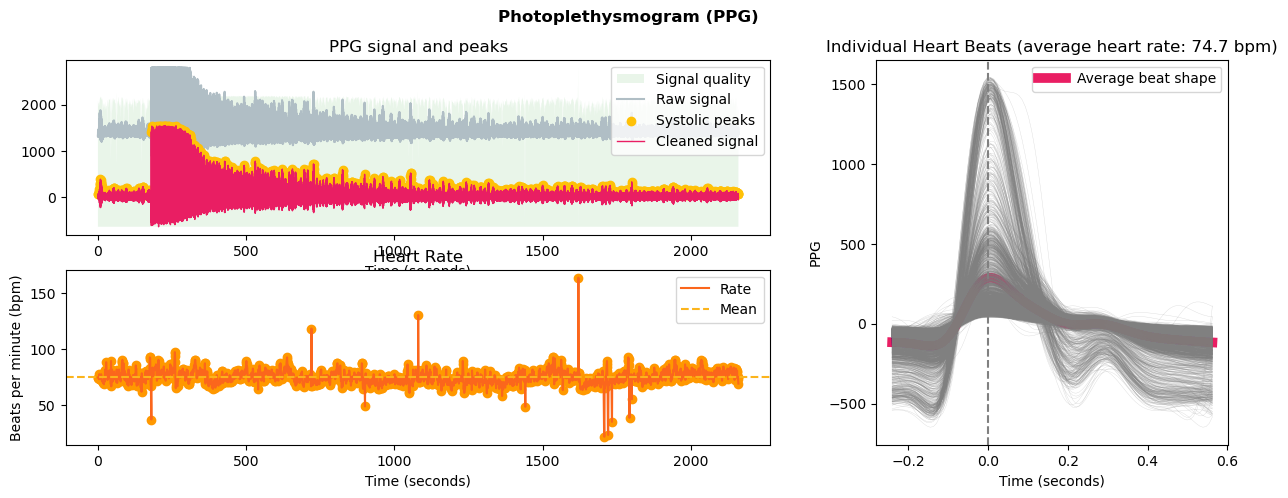

In [ ]:
signals, info = nk.ppg_process(
    ppg.select(PPG_RAW_COLUMN).to_numpy().flatten(), sampling_rate=128
)

# Visualize the processing
nk.ppg_plot(signals, info)

<Axes: >

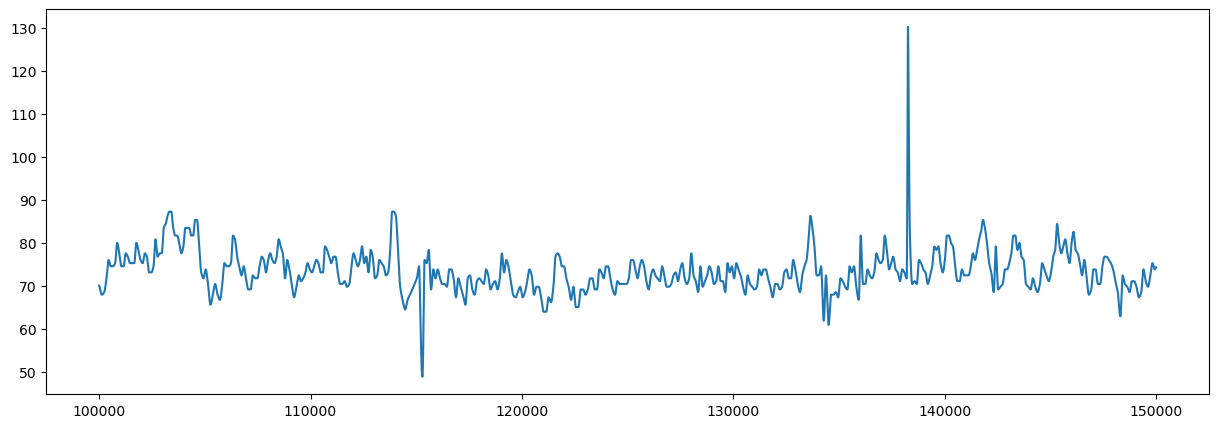

In [ ]:
signals["PPG_Rate"][100000:150000].plot()

In [ ]:
ppg.filter(pl.col("Trial") == 1).select(PPG_RAW_COLUMN).to_numpy().flatten()

array([ 975.09157509,  942.85714286,  945.78754579, ..., 1104.76190476,
       1087.91208791, 1135.53113553])

In [ ]:
ppg_cleaned = nk.ppg_clean(
    ppg.filter(pl.col("Trial") == 0).select(PPG_RAW_COLUMN).to_numpy().flatten(),
    sampling_rate=128,
)
quality = nk.ppg_quality(ppg_cleaned, sampling_rate=128, method="templatematch")

In [ ]:
ppg_cleaned

array([ -8.39501061, -10.6761519 , -12.83358223, ...,   1.7565179 ,
        -0.31412241,  -2.67527293])

In [ ]:
ppg.filter(pl.col("Trial") == 0).plot(
    x="Timestamp", y=PPG_RAW_COLUMN, kind="line", width=800, height=400
)

:Curve   [Timestamp]   (PPG_RAW)

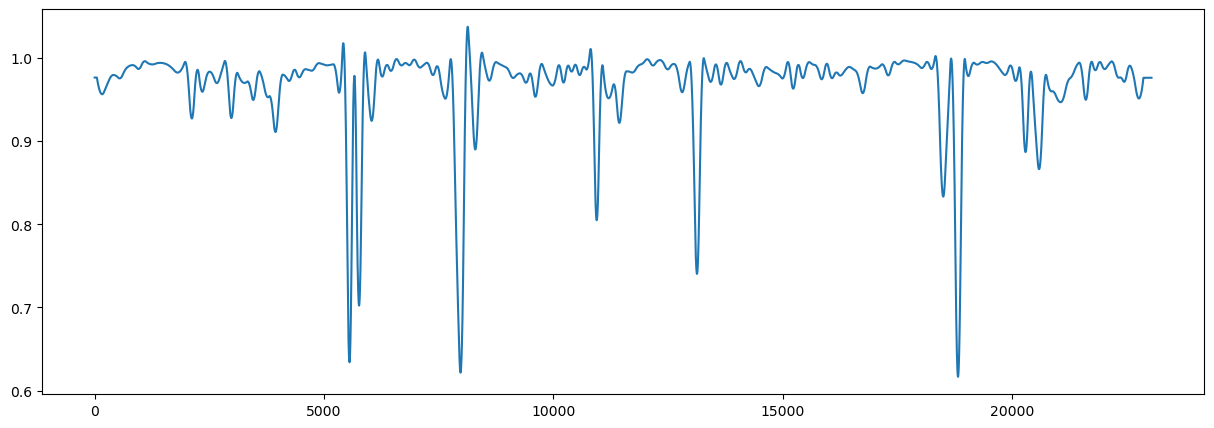

In [ ]:
from matplotlib import pyplot as plt

plt.plot(quality)

In [ ]:
ppg.filter(pl.col("Trial") == 4).plot(x="Timestamp", y=PPG_RAW_COLUMN, kind="line")

:Curve   [Timestamp]   (PPG_RAW)

In [ ]:
# nk.ppg_quality(signals, sampling_rate=100)

In [ ]:
signals, info

(            PPG_Raw  PPG_Clean   PPG_Rate  PPG_Quality  PPG_Peaks
 0       1327.472527  -8.395011  74.632976     0.972105          0
 1       1312.087912 -10.676152  74.632976     0.972105          0
 2       1328.205128 -12.833582  74.632976     0.972105          0
 3       1306.959707 -14.754678  74.632976     0.972105          0
 4       1331.868132 -16.372540  74.632976     0.972105          0
 ...             ...        ...        ...          ...        ...
 276510  1364.835165  -8.128251  69.189189     0.926696          0
 276511  1402.930403  -8.158909  69.189189     0.926696          0
 276512  1368.498168  -8.330653  69.189189     0.926696          0
 276513  1384.615385  -8.610829  69.189189     0.926696          0
 276514  1374.358974  -8.933646  69.189189     0.926696          0
 
 [276515 rows x 5 columns],
 {'method_peaks': 'elgendi',
  'method_fixpeaks': 'None',
  'PPG_Peaks': array([    48,    151,    254, ..., 276231, 276336, 276447]),
  'sampling_rate': 128})

In [ ]:
import neurokit2 as nk
import pandas as pd
import polars as pl

EDA_RAW_COLUMN = "EDA_RAW"


@map_trials
def process_eda(
    df: pl.DataFrame,
    sampling_rate: int = 100,
) -> pl.DataFrame:
    eda_raw = df.select(EDA_RAW_COLUMN).to_numpy().flatten()
    eda_processed: pd.DataFrame = nk.eda_phasic(
        eda_signal=eda_raw,
        sampling_rate=sampling_rate,
        method="neurokit",
    )  # returns EDA_Phasic and EDA_Tonic columns
    return df.hstack(pl.from_pandas(eda_processed))